# Intro Plot

In [2]:
import json
import os
import pandas as pd
import numpy as np
import statistics

from pathlib import Path

In [227]:
directory = "/Users/martin/Programming/column-compression/data/intro_plot"

hostname_to_cpu_map = {"nemea": "Intel Xeon 8180",
                       "lenovo2": "AMD EPYC 7452",
                       "hyrise-mac-m1": "Apple M1"}

result_folders = {"nemea": "nemea_hyriseBenchmarkTPCH_segmentencoding20210627",
                  "lenovo2": "lenovo2_hyriseBenchmarkTPCH_segmentencoding20210627",
                  "hyrise-mac-m1": "hyrise-mac-m1_hyriseBenchmarkTPCH_segmentencoding20210627"}

results = pd.DataFrame()

for hostname in ["nemea", "lenovo2", "hyrise-mac-m1"]:
    host_directory = Path(os.path.join(directory, result_folders[hostname]))
    for intro_encoding in ["Unencoded", "Dictionary", "FrameOfReference", "CompactVector"]:
        results_json = None
        result_file = os.path.join(host_directory, f"hyriseBenchmarkTPCH_{intro_encoding}_sf10_singlethreaded.json")
        result_file_alt = os.path.join(host_directory, f"hyriseBenchmarkTPCH_{intro_encoding}_singlethreaded.json")
        if Path(result_file).exists():
            with open(result_file, "r") as json_file:
                results_json = json.load(json_file)
        else:
            if Path(result_file_alt).exists():
                with open(result_file_alt, "r") as json_file:
                    results_json = json.load(json_file)
            else:
                print(f"No results for {intro_encoding} on {hostname}.")
                continue
        
        assert len(results_json['benchmarks']) == 22
        cumu_median_runtimes = 0.0
        for benchmark in results_json['benchmarks']:
            runtimes = []
            for run in benchmark['successful_runs']:
                runtimes.append(run['duration'])
            cumu_median_runtimes += statistics.median(runtimes)
        
        size_file_path = os.path.join(host_directory, f"sizes_hyriseBenchmarkTPCH_{intro_encoding}.txt")
        if not Path(size_file_path).exists():
            size_file_path = os.path.join(host_directory, f"sizes_{intro_encoding}.txt")
            assert Path(size_file_path).exists(), f"{size_file_path} does not exist."

        int_size = 0.0
        with open(size_file_path, "r") as size_file:
            track = False

            for line in size_file:
                if line.startswith('=== Chunk 0 ==='):
                    track = True
                    continue
                
                if not track or line.startswith('|<ValueS>') or not line.startswith('|'):
                    continue
                
                items = line.split("|")
                if items[5].strip() == "int" or items[5].strip() == "double":
                    int_size += int(items[9].strip())

        results = results.append({"hostname": hostname, "encoding": intro_encoding, "int_size_in_bytes": int_size,
                                  "int_size_in_mb": int_size / 1000 / 1000, "cpu": hostname_to_cpu_map[hostname],
                                  "runtime_s": cumu_median_runtimes / 1000 / 1000 / 1000}, ignore_index=True)

results['encoding'] = results['encoding'].str.replace('Unencoded', 'std::vector<int>')
results['encoding'] = results['encoding'].str.replace('CompactVector', 'Bitpacking')
results['encoding'] = results['encoding'].str.replace('FrameOfReference', 'Frame Of Reference')
display(results)

,cpu,encoding,hostname,int_size_in_bytes,int_size_in_mb,runtime_s
0,Intel Xeon 8180,std::vector<int>,nemea,1.266756e+09,1266.756060,33.166858
1,Intel Xeon 8180,Dictionary,nemea,1.372782e+09,1372.782099,38.554859
2,Intel Xeon 8180,Frame Of Reference,nemea,9.912806e+08,991.280615,35.798953
3,Intel Xeon 8180,Bitpacking,nemea,6.553721e+08,655.372072,34.722399
4,AMD EPYC 7452,std::vector<int>,lenovo2,1.266756e+09,1266.756060,42.072741
5,AMD EPYC 7452,Dictionary,lenovo2,1.372782e+09,1372.782099,53.305547
6,AMD EPYC 7452,Frame Of Reference,lenovo2,9.912806e+08,991.280615,44.831092
7,AMD EPYC 7452,Bitpacking,lenovo2,6.553721e+08,655.372072,43.402464
8,Apple M1,std::vector<int>,hyrise-mac-m1,1.266795e+09,1266.794740,20.016037
9,Apple M1,Dictionary,hyrise-mac-m1,1.372782e+09,1372.782099,23.262086


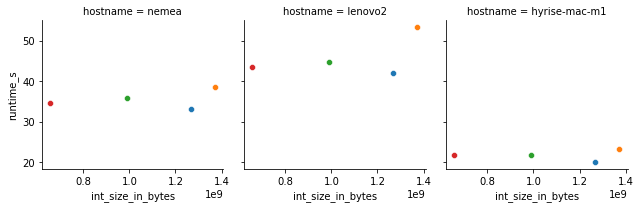

In [228]:
import seaborn
import matplotlib.pyplot as plt

g = seaborn.FacetGrid(results, col="hostname", hue="encoding")#, sharex=False, sharey=False)
g.map(seaborn.scatterplot, "int_size_in_bytes", "runtime_s")

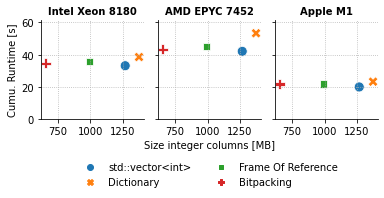

In [229]:
g = seaborn.relplot(data=results, x="int_size_in_mb", y="runtime_s", col="cpu", hue="encoding",
                    style="encoding", height=2.3, aspect=0.8, s=100)
g.set_titles("{col_name}", fontdict= { 'fontweight':'bold'})
g.set_axis_labels("Size integer columns [MB]", "Cumu. Runtime [s]")
g.tight_layout()

plt.ylim(0, max(results['runtime_s'])*1.15)
for ax in g.axes.flat:
    ax.grid(True, axis='both', linestyle='dotted')
    
g.axes.flatten()[0].set(xlabel=None)
g.axes.flatten()[2].set(xlabel=None)

handles, labels = g.fig.axes[0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=2, loc='upper center', bbox_to_anchor=(0.4, 0.05), frameon=False)
# g.fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.75, 0.9))

g.savefig("intro_plot.pdf")